In [2]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
from aix360.datasets import ClimateDataset
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tssaliency.tssaliency import TSSaliencyExplainer
from aix360.algorithms.tsutils.model_wrappers import Tensor_Based_Forecaster
from huggingface_hub.utils import logging as h_logging

# huggingface hub warnings
h_logging.set_verbosity_error()

/home/kxlu/anaconda3/envs/aix360py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
datasets = ClimateDataset().load_data(return_train=False, test_start=100551)
df = datasets["df"]
df.head()

,p (mbar),T (degC),VPmax (mbar),VPdef (mbar),sh (g/kg),rho (g/m**3),wv (m/s)
0,0.955451,-2.000020,-1.319782,-0.788479,-1.500927,2.237658,-0.732997
1,0.961528,-2.045185,-1.332806,-0.790561,-1.519521,2.287838,-0.936002
2,0.956666,-2.056766,-1.335410,-0.792642,-1.523239,2.298608,-1.283076
3,0.954236,-2.033604,-1.328898,-0.794724,-1.508364,2.272906,-1.184847
4,0.954236,-2.028972,-1.327596,-0.794724,-1.508364,2.268256,-1.197944


In [5]:
selected_feature_columns = datasets["selected_feature_columns"]
selected_feature_names = datasets["selected_feature_names"]
sequence_length = datasets["sequence_length"]
x_test = datasets["x_test"]
y_test = datasets["y_test"]
timestamps = datasets["timestamps"]

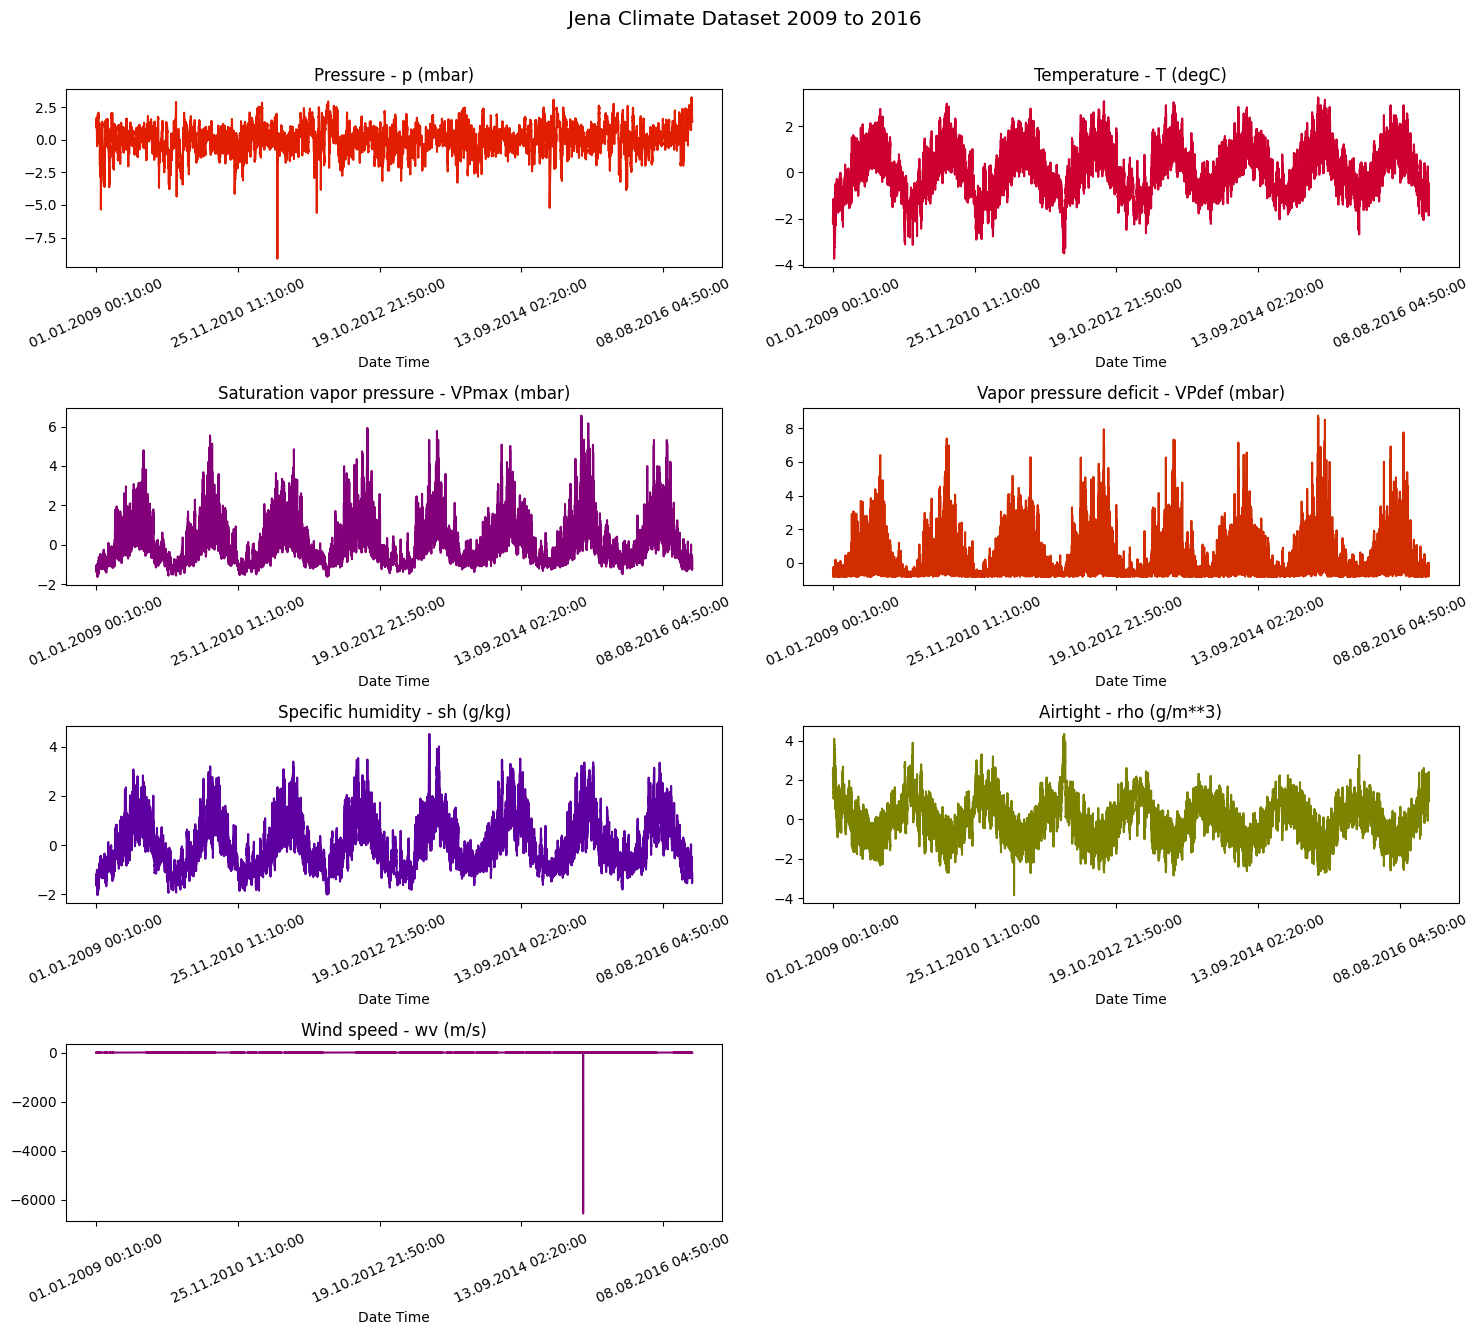

In [6]:
import matplotlib

np.random.seed(242)
cmap = matplotlib.cm.brg
colors = cmap(np.random.choice(np.arange(256), len(selected_feature_columns)))

fig = plt.figure(figsize=(15,14))

for i, feature_col in enumerate(selected_feature_columns):
    feature_data = df[feature_col]
    feature_data.index = timestamps
    ax = fig.add_subplot(int((len(selected_feature_columns) + 1) / 2), 2, i+1)
    ax = feature_data.plot(
        ax=ax,
        color=colors[i],
        title="{} - {}".format(selected_feature_names[i], feature_col),
        rot=25,
    )
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

fig.suptitle("Jena Climate Dataset 2009 to 2016", fontsize="x-large")
plt.show()

In [7]:
model = from_pretrained_keras("keras-io/timeseries_forecasting_for_weather")
model.summary()

Fetching 9 files: 100%|██████████| 9/9 [00:02<00:00,  3.73it/s]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120, 7)]          0         
                                                                 
 lstm (LSTM)                 (None, 32)                5120      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,153
Trainable params: 5,153
Non-trainable params: 0
_________________________________________________________________


In [8]:
f_model = Tensor_Based_Forecaster(model=model, forecast_function="predict", input_length=sequence_length, n_features = len(selected_feature_columns))

In [9]:
import functools

explainer = TSSaliencyExplainer(model=functools.partial(f_model.predict, verbose = 0),
                        input_length=sequence_length,
                        feature_names=selected_feature_names,
                        n_samples=50,
                        gradient_samples=1000,
                            )
indx = 0
instance = x_test[indx]
base_value = np.mean(instance, axis=0)

ts_instance = tsFrame(instance)
ts_instance.index = pd.to_numeric(ts_instance.index)
explanation = explainer.explain_instance(ts_instance,base_value=base_value)

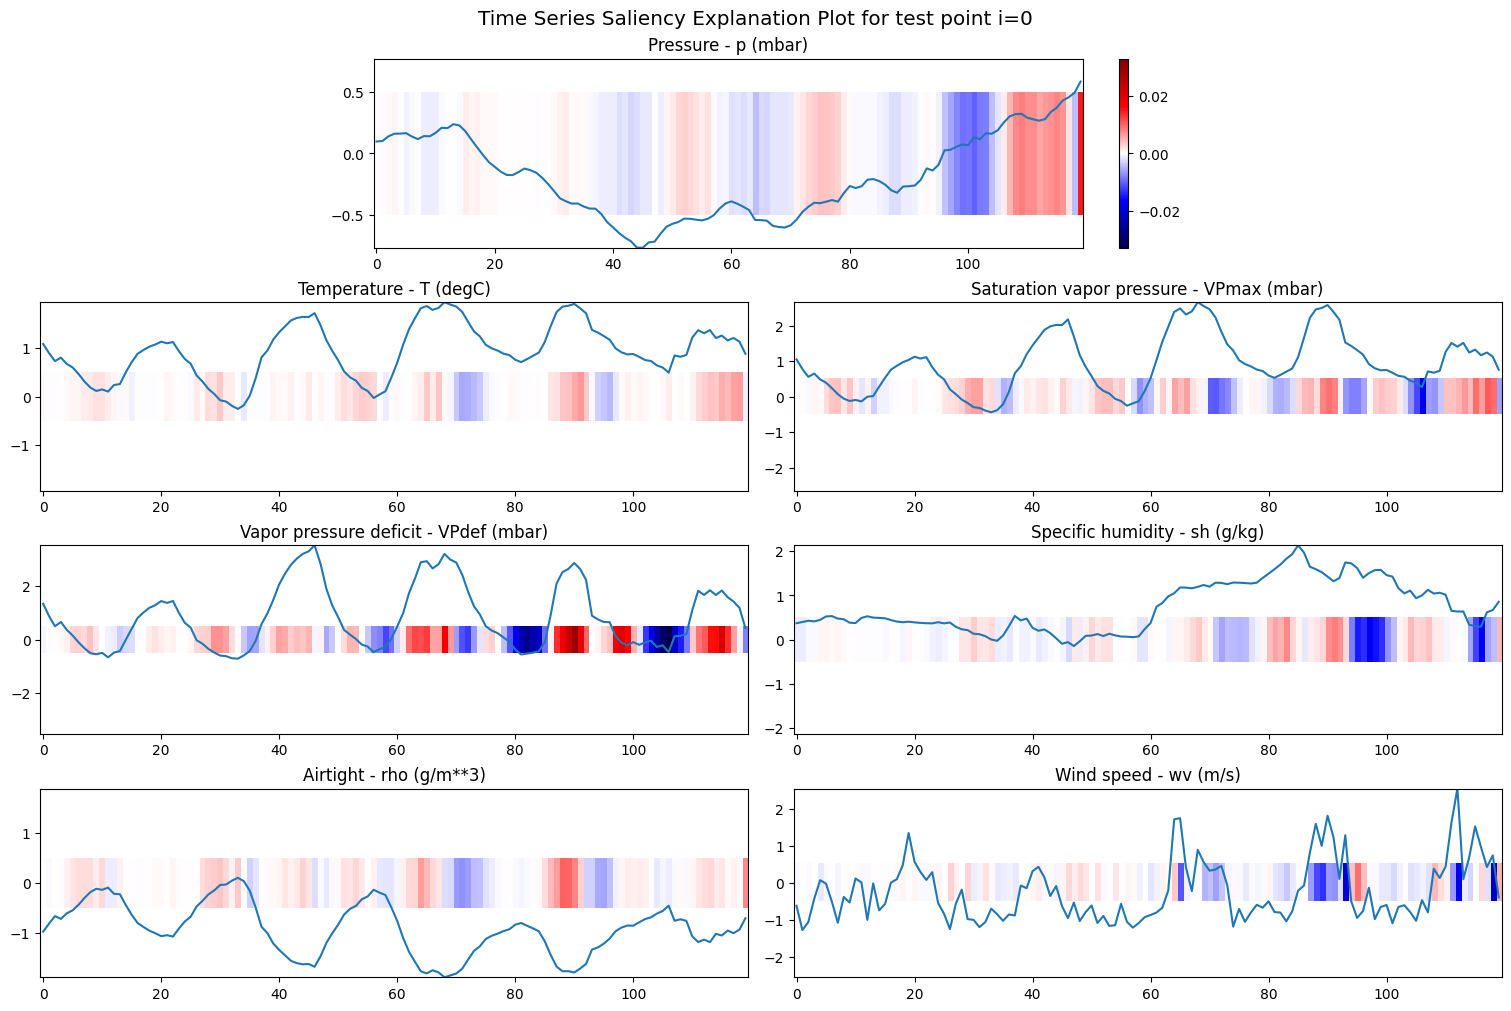

In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(layout='constrained', figsize=(15,10))
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios= [1, 3], top=0.9)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], width_ratios=[4.5, 10, 4.5])


def plot_feature(figure, scores, feature_values, vmax, gs, title, colorbar=False):
    ax = fig.add_subplot(gs)
    offset = np.nanmean(feature_values)
    y_max = np.max([np.max(np.abs(feature_values)), vmax])
    image = ax.imshow(scores,
                      aspect='auto',
                      cmap='seismic',
                      vmin=-vmax,
                      vmax=vmax)
    ax.plot(feature_values)
    
    ax.set_ylim(top=y_max, bottom=-y_max)
    ax.set_title(title)
    if colorbar:
        plt.colorbar(mappable=image)

max_abs = np.max(np.abs(explanation['saliency']))
for i, feature_col in enumerate(selected_feature_columns):
    if i > 0:
        gs = gs2[i-1]
    else:
        gs = gs1[1]
        
    plot_feature(figure=fig,
                 scores=explanation['saliency'][:,i].reshape(-1, sequence_length, 1), 
                 feature_values=instance[:,i],
                 vmax=max_abs,
                 gs=gs,
                 title="{} - {}".format(selected_feature_names[i], feature_col),
                 colorbar=(i==0))

fig.suptitle("Time Series Saliency Explanation Plot for test point i={}".format(str(indx)), fontsize="x-large")
plt.show()

### LIME

In [14]:
import functools
from aix360.algorithms.tslime.tslime import TSLimeExplainer
from aix360.algorithms.tsutils.tsperturbers import BlockBootstrapPerturber

relevant_history = 40
explainer = TSLimeExplainer(
                            model= functools.partial(f_model.predict, verbose = 0),
                            input_length=sequence_length,
                            relevant_history=relevant_history,
                            perturbers=[
                                BlockBootstrapPerturber(window_length=min(10, sequence_length-1), block_length=2, block_swap=2),
                            ],
                            n_perturbations=10000,
                            random_seed=22,
                        )
explanation = explainer.explain_instance(ts_instance)

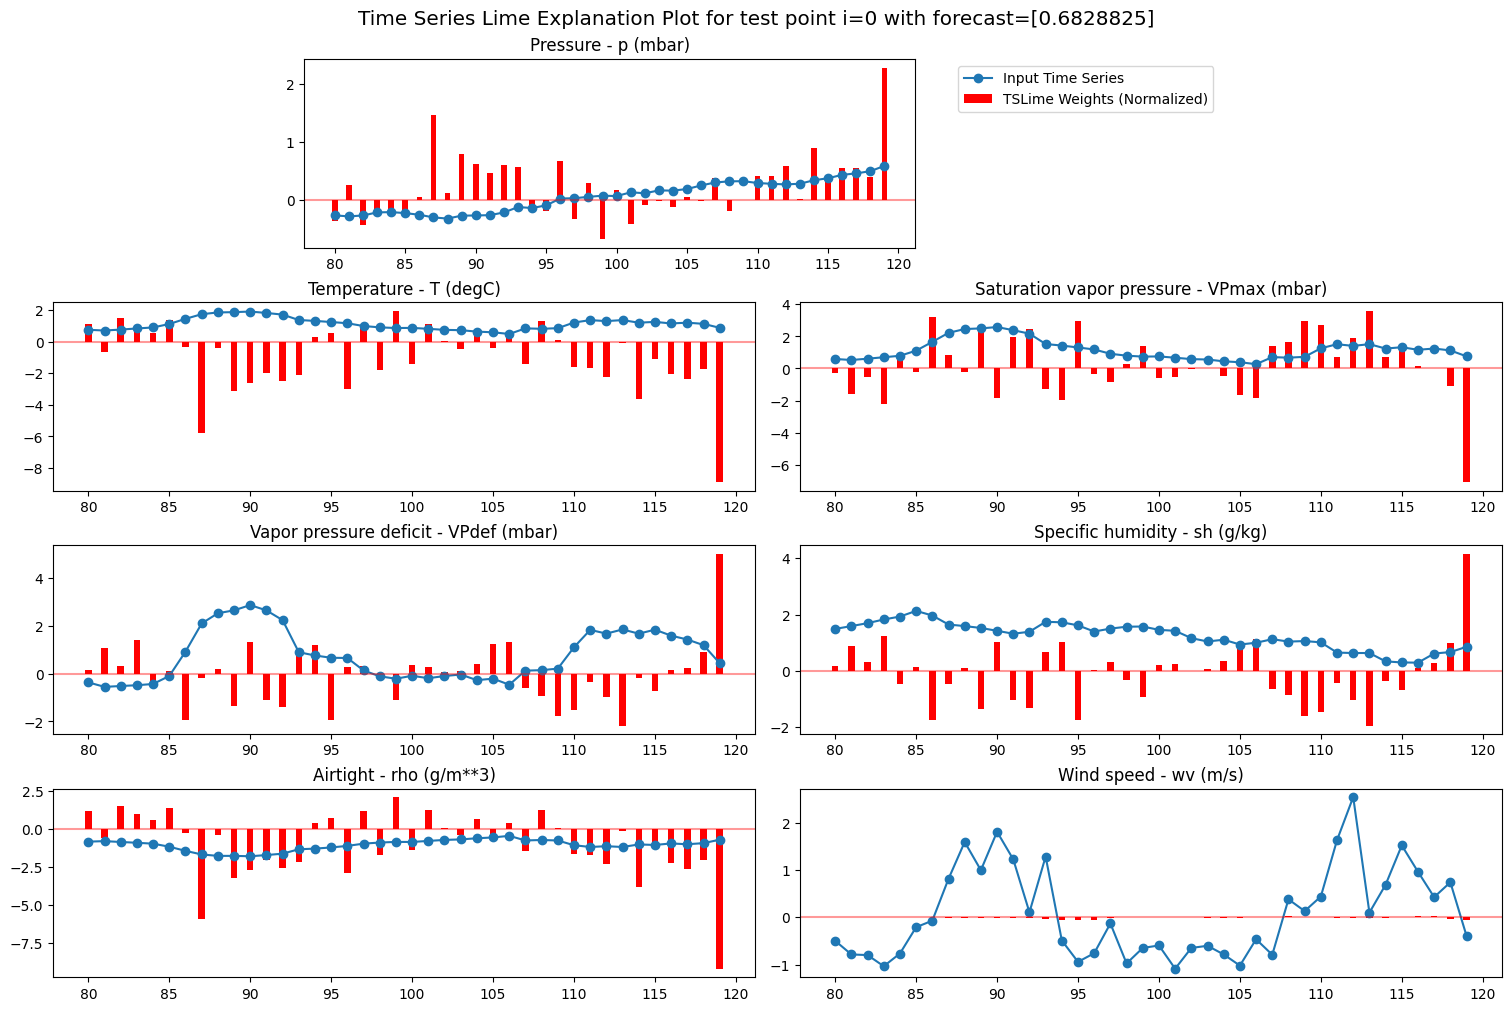

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(layout='constrained', figsize=(15,10))
gs0 = gridspec.GridSpec(2, 1, figure=fig, height_ratios= [1, 3], top=0.9)
gs2 = gridspec.GridSpecFromSubplotSpec(3, 2, subplot_spec=gs0[1])
gs1 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0], width_ratios=[4.5, 10, 4.5])

        
def plot_feature(figure, scores, feature_values, gs, title, legend=False):
    ax = fig.add_subplot(gs)
    ax.plot(feature_values, label='Input Time Series', marker='o')
    # plt.gca().invert_yaxis()
    ax.set_title(title)

    ax.bar(feature_values.index, scores, 0.4, label = 'TSLime Weights (Normalized)', color='red')
    ax.axhline(y=0, color='r', linestyle='-', alpha=0.4)
    if legend:
        ax.legend(bbox_to_anchor=(1.5, 1.0), loc='upper right')

    
instance_prediction = explanation['model_prediction']
normalized_weights = (explanation['history_weights'] / np.mean(np.abs(explanation['history_weights'])))

for i, feature_col in enumerate(selected_feature_columns):
    if i > 0:
        gs = gs2[i-1]
    else:
        gs = gs1[1]
        
    
    plot_feature(figure=fig,
                 scores=normalized_weights[:,i].flatten(), 
                 feature_values=ts_instance.iloc[-relevant_history:, i],
                 gs=gs,
                 title="{} - {}".format(selected_feature_names[i], feature_col),
                 legend=(i==0))

fig.suptitle("Time Series Lime Explanation Plot for test point i={} with forecast={}".format(str(indx), str(instance_prediction)), fontsize="x-large")
plt.show()

In [22]:
from aix360.algorithms.tsice.tsice import TSICEExplainer
explainer_with_latest_window = TSICEExplainer(
            forecaster=functools.partial(f_model.predict, verbose = 0),
            explanation_window_start=None,
            explanation_window_length=sequence_length,
            features_to_analyze=[
                'mean', # analyze mean metric from recent time series of lengh <observation_length> 
                'median', # analyze median metric from recent time series of lengh <observation_length> 
                'std', # analyze std metric from recent time series of lengh <observation_length> 
                'max_variation', # analyze max_variation metric from recent time series of lengh <observation_length> 
                'min',
                'max',
                'range',
                'intercept',
                'trend',
                'rsquared',
            ],
            perturbers=[
                                BlockBootstrapPerturber(window_length=min(10, sequence_length-1), block_length=2, block_swap=2),
                            ],
            input_length=sequence_length,
            forecast_lookahead=1,
            n_perturbations=250,
        )